In [2]:
import numpy as np
import os
import cv2
import random
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import applications, losses, optimizers, metrics, Model, layers
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, vgg16, resnet
from keras import ops

from matplotlib import gridspec
from matplotlib.image import imread
import matplotlib.pyplot as plt

In [3]:
data_path = "C:/Users/Tymof/OneDrive/Desktop/education/Practice/Hackaton/data/train"
target_shape = (224,224)

In [4]:
class PreProcessing:

    images_train = np.array([])
    labels_train = np.array([])
    unique_train_label = np.array([])
    map_train_label_indices = dict()

    def __init__(self,data_src):
        self.data_src = data_src
        print("Loading the Dataset...")
        self.images_train, self.labels_train = self.preprocessing()
        self.unique_train_label = np.unique(self.labels_train)
        self.map_train_label_indices = {label: np.flatnonzero(self.labels_train == label) for label in
                                        self.unique_train_label}
        print('Preprocessing Done. Summary:')
        print("Images train :", self.images_train.shape)
        print("Labels train :", self.labels_train.shape)
        print("Unique label :", self.unique_train_label)

    def normalize(self,x):
        min_val = np.min(x)
        max_val = np.max(x)
        x = (x - min_val) / (max_val - min_val)
        return x

    def read_dataset(self):    
        count = 0
        for directory in os.listdir(self.data_src):
            count += len([file for file in os.listdir(os.path.join(self.data_src, directory))[:100]])

        X = [None] * count
        y = [None] * count
        idx = 0

        for directory in os.listdir(self.data_src):
            try:
                print('Read directory: ', directory)
                for pic in os.listdir(os.path.join(self.data_src, directory))[:100]:
                    img = imread(os.path.join(self.data_src, directory, pic))
                    if len(img.shape)<3:
                        continue
                    img = tf.image.resize(img, (224,224))
                    img = self.normalize(img)

                    X[idx] = np.squeeze(np.asarray(img))
                    y[idx] = directory
                    idx += 1

            except Exception as e:
                print('Failed to read images from Directory: ', directory)
                print('Exception Message: ', e)
        print('Dataset loaded successfully.')
        return X,y

    def preprocessing(self):
        X, y = self.read_dataset()

        labels = list(set(y))
        label_dict = dict(zip(labels, range(len(labels))))
        Y = np.asarray([label_dict[label] for label in y])        

        X_resized = np.zeros((len(X), 224, 224, 3), dtype=np.float32)
        for i, img in enumerate(X):
            X_resized[i] = img 

        return X_resized, Y


    def get_triplets(self):
        label_l, label_r = np.random.choice(self.unique_train_label, 2, replace=False)
        a, p = np.random.choice(self.map_train_label_indices[label_l],2, replace=False)
        n = np.random.choice(self.map_train_label_indices[label_r])
        return a, p, n

    def get_triplets_batch(self):
        idxs_a, idxs_p, idxs_n = [], [], []
        n = len(self.labels_train)
        for _ in range(n):
            a, p, n = self.get_triplets()
            idxs_a.append(a)
            idxs_p.append(p)
            idxs_n.append(n)
            
        anchor_dataset = tf.data.Dataset.from_tensor_slices(self.images_train[idxs_a,:])
        positive_dataset = tf.data.Dataset.from_tensor_slices(self.images_train[idxs_p,:])
        negative_dataset = tf.data.Dataset.from_tensor_slices(self.images_train[idxs_n, :])

        dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
        
        return dataset


In [5]:
dataset = PreProcessing(data_path)

Loading the Dataset...
Read directory:  alert
Read directory:  button
Read directory:  card
Read directory:  checkbox_checked
Read directory:  checkbox_unchecked
Read directory:  chip
Read directory:  data_table
Read directory:  dropdown_menu
Read directory:  floating_action_button
Read directory:  grid_list
Read directory:  image
Read directory:  label
Read directory:  menu
Read directory:  radio_button_checked
Read directory:  radio_button_unchecked
Read directory:  slider
Read directory:  switch_disabled
Read directory:  switch_enabled
Read directory:  text_area
Read directory:  text_field
Read directory:  tooltip
Dataset loaded successfully.
Preprocessing Done. Summary:
Images train : (2100, 224, 224, 3)
Labels train : (2100,)
Unique label : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [6]:
data = dataset.get_triplets_batch()


In [7]:
count = len(dataset.labels_train)


In [8]:
train_dataset = data.take(round(count * 0.8))
val_dataset = data.skip(round(count * 0.8))

In [9]:
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)


(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


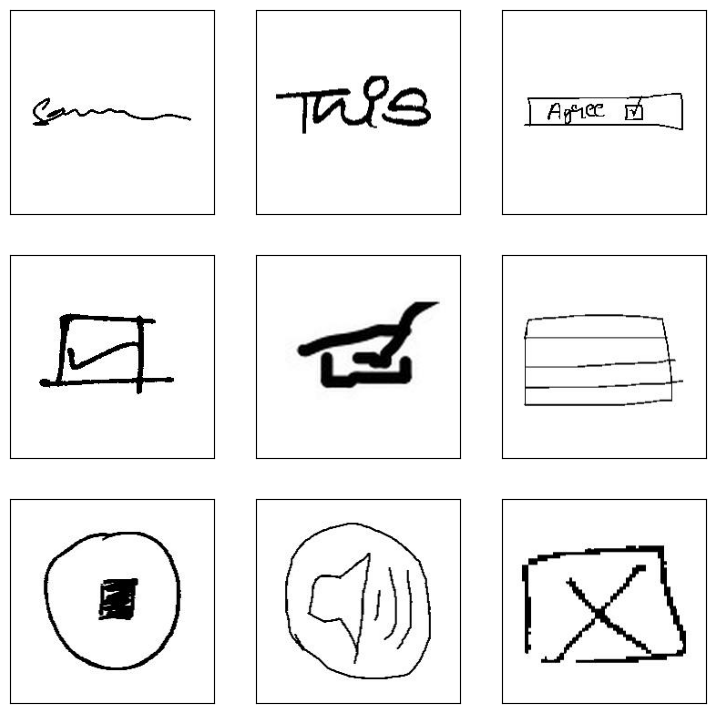

In [9]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        print(image.shape)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])


In [10]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable


In [11]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)


In [12]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):

        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # List metrics here so the `reset_states()` can be called automatically.
        return [self.loss_tracker]


In [14]:
siamese_model = SiameseModel(siamese_network)
# callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5,min_delta=0.005, mode='max', verbose=1),
#  ModelCheckpoint('sw.weights.h5', monitor='val_accuracy', mode='max', save_best_only=True, save_weights_only=True),
#  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
siamese_model.compile(optimizer=optimizers.Adam(0.001))
siamese_model.fit(train_dataset, epochs=3, validation_data=val_dataset,verbose=1)


Epoch 1/3


: 

In [ ]:
model_save_path = 'siamese_weights'

# Save the model
siamese_model.save_weights(model_save_path)

In [ ]:
siamese_model.predict("./data/train/button/0aacaf07-d9eb-4f37-ab0e-ebb456d06cce.jpg")

IndexError: tuple index out of range